In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import glob
import re
import xclim
import pandas as pd

import sys
sys.path.append('/data/met/processing/10_methods/')
import regridding as rg
import ceda_compliance as ceda
from plotting import vrange, rcm_colours

import matplotlib.pyplot as plt
from matplotlib import cm
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# squash annoying warning about creating large chunks
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

wp = xr.open_dataset("/data/met/processing/01_maps/wp_definitions_mean_anoms_emulate_1850_2003.nc")

---
### **Methods**

#### **Compute anomalies vs smoothed climatology**

In [2]:
def psl_anomalies(da):
    
    # smooth the full time series & select the climatology period
    hist_sm = da.rolling(time = 3, center = True).mean().rolling(time = 15, center = True).mean().rolling(time = 31, center = True).mean().sel(time = slice("18991201", "19991130"))
    
    # compute climatology from smoothed historical runs
    clim = hist_sm.groupby(hist_sm.time.dt.dayofyear).mean()
    
    proj = da.sel(time = slice("19801201", "20801130"))
    
    anom = proj.groupby(proj.time.dt.dayofyear) - clim
    
    return anom

In [3]:
# match weather types
def weather_types(da, wp = wp.met_office_pmsl_anomaly_weather_regime_definitions_for_the_set_of_30):
    
    area_weights = np.cos(da.latitude * np.pi/180)
    area_weights = np.tile(np.array([area_weights]).transpose(), (1, len(da.longitude)))
    
    # compute AREA-WEIGHTED sums of squares wrt each regime
    ss = []
    corrs = []
    for r in wp.regime.values:
        corrs.append(xr.corr(wp.sel(regime = r), da, dim = ["latitude", "longitude"]))
        ss.append((area_weights * ((da - wp.sel(regime = r))**2)).sum(dim = ["latitude", "longitude"]))
        
    ss = xr.concat(ss, dim = "regime").rename("ss")
    corrs = xr.concat(corrs, dim = "regime").rename("corr")
    
    #  find minimising regime at each time step
    wtype = (ss.argmin(dim = "regime") + 1).rename("wtype30")
    
    # Condense the 30 weather patterns into 8 weather types using a lookup
    wt8_lookup = [3, 4, 6, 2, 5, 1, 7, 2, 1, 8, 1, 4, 3, 3, 4, 5, 5, 6, 1, 2, 4, 5, 2, 3, 1, 2, 1, 1, 7, 2]
    wtype8 = xr.apply_ufunc(lambda x: np.array(wt8_lookup)[x.astype(int)], wtype - 1).rename("wtype8")
    
    return wtype, wtype8, ss, corrs

---
### **Check method by computing weather types for UKCP18 GCM output**

In [10]:
# open GCM data & relabel/reorder longitudes
gcm = xr.open_mfdataset("../../ukcp18/01/dmo/psl*gcm_global*.nc")
gcm = gcm.assign_coords(longitude=(((gcm.longitude + 180) % 360) - 180))
gcm = gcm.reindex({ "longitude" : np.sort(gcm.longitude)})

# regrid to weather pattern domain (use conservative regridding, because upscaling)

gcm_rg = xe.Regridder(gcm, wp, "conservative")(gcm.psl).compute()             # force computation of regridding - otherwise gets very slow later

# compute anomalies & match to weather types
gcm_anom = psl_anomalies(gcm_rg)
wtype30, wtype8, ss, corr = weather_types(gcm_anom)

wtype30.to_netcdf("../../ukcp18/01/ka2/wtype30_rcp85_land-indices_01_day_19801201-20801130-COMPUTED.nc")

# compare output to weather types downloaded from CEDA
ceda_types = xr.open_dataset("../../ukcp18/01/ka2/wtype30_rcp85_land-indices_01_day_18991201-20991130.nc").sel(time = slice("19801201", "20801130")).wtype30

fig=plt.figure(figsize=(9,3), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
wtype30[0,0:100].plot()
ceda_types[0,0:100].plot()
plt.title("First 100 30-day weather types")

wt8_lookup = [3, 4, 6, 2, 5, 1, 7, 2, 1, 8, 1, 4, 3, 3, 4, 5, 5, 6, 1, 2, 4, 5, 2, 3, 1, 2, 1, 1, 7, 2]
ceda_wtype8 = xr.apply_ufunc(lambda x: np.array(wt8_lookup)[x.astype(int)], ceda_types - 1)

plt.subplot(1,2,2)
wtype8[0,0:100].plot()
ceda_wtype8[0,0:100].plot()
plt.title("First 100 8-day weather types")

print()
print(str(((wtype30 == ceda_types).mean().values * 100).round(1)) + "% of wtype30 matched")
print(str(((wtype8 == ceda_wtype8).mean().values * 100).round(1)) + "% of wtype8 matched")
print()

---
### **'Observed' weather types from EMULATE**

In [4]:
# load weather patterns (provided by Rob Neal at the Met Office) & EMULATE MSLP fields
wp = xr.open_dataset("../01_maps/wp_definitions_mean_anoms_emulate_1850_2003.nc")

emu = xr.open_dataset("/data/met/processing/03_additional_data/emulate_3.2_1850-2003.nc")

# select required area
emu = emu.sel(lat = slice(70.,35.), lon = slice(-30., 20.)).rename(lat = "latitude", lon = "longitude")
emu = xclim.units.convert_units_to(emu.mslp, "hPa")

emu_anom = psl_anomalies(emu).sel(time = slice("19801201", "20101130"))
wtype30, wtype8, ss, corr = weather_types(emu_anom)

emu_fnm = "/data/met/processing/03_additional_data/wtype30_emulate-3.2_19801201-20001130.nc"

wtype30.to_netcdf(emu_fnm)
wtype8.to_netcdf(re.sub("wtype30", "wtype8", emu_fnm))
    
ss.to_netcdf(re.sub("wtype30", "wtype30-ss", emu_fnm))
corr.to_netcdf(re.sub("wtype30", "wtype30-corr", emu_fnm))

/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [5]:
# also save the climatology: needed to compute ERA-Interim weather types
hist_sm = emu.rolling(time = 3, center = True).mean().rolling(time = 15, center = True).mean().rolling(time = 31, center = True).mean().sel(time = slice("18991201", "19991130"))
    
# compute climatology from smoothed historical runs
clim = hist_sm.groupby(hist_sm.time.dt.dayofyear).mean()
clim.to_netcdf("/data/met/processing/03_additional_data/psl-climatology_emulate-3.2_18991201-19991130.nc")

#### **`Observed' weather types from ERA-Interim**

ERA-Interim doesn't extend far enough back to compute its own climatology - use EMULATE climatology instead

In [8]:
# Load ERA-Interim MSLP fields & regrid to weather-type resolution
wp = xr.open_dataset("../01_maps/wp_definitions_mean_anoms_emulate_1850_2003.nc")
clim = xr.open_dataset("/data/met/processing/03_additional_data/psl-climatology_emulate-3.2_18991201-19991130.nc").mslp

era_ds = xr.open_mfdataset("/data/met/ECMWF-ERAINT/dmo/psl-NAEU_ECMWF-ERAINT_day_19801201-20111130.nc")
era = xe.Regridder(era_ds, wp, "conservative")(era_ds.psl.resample(time = "D").mean())
era = era.assign_coords(time = era.time + np.timedelta64(12, "h"))

wp = wp.met_office_pmsl_anomaly_weather_regime_definitions_for_the_set_of_30

In [9]:
era_anom = (era.groupby(era.time.dt.dayofyear) - clim).load()

In [10]:
da = era_anom
area_weights = np.cos(da.latitude * np.pi/180)
area_weights = np.tile(np.array([area_weights]).transpose(), (1, len(da.longitude)))

# compute AREA-WEIGHTED sums of squares wrt each regime
ss = []
corrs = []
for r in wp.regime.values:
    corrs.append(xr.corr(wp.sel(regime = r), da, dim = ["latitude", "longitude"]))
    ss.append((area_weights * ((da - wp.sel(regime = r))**2)).sum(dim = ["latitude", "longitude"]))

ss = xr.concat(ss, dim = "regime").rename("ss")
corrs = xr.concat(corrs, dim = "regime").rename("corr")

# find minimising regime at each time step
wtype = (ss.argmin(dim = "regime") + 1).rename("wtype30")

# Condense the 30 weather patterns into 8 weather types using a lookup
wt8_lookup = [3, 4, 6, 2, 5, 1, 7, 2, 1, 8, 1, 4, 3, 3, 4, 5, 5, 6, 1, 2, 4, 5, 2, 3, 1, 2, 1, 1, 7, 2]
wtype8 = xr.apply_ufunc(lambda x: np.array(wt8_lookup)[x.astype(int)], wtype - 1).rename("wtype8")

In [11]:
era_fnm = "/data/met/ECMWF-ERAINT/ka2/wtype30_ECMWF-ERAINT_day_19801201-20111130.nc"

wtype.to_netcdf(era_fnm)
wtype8.to_netcdf(re.sub("wtype30", "wtype8", era_fnm))
    
ss.to_netcdf(re.sub("wtype30", "wtype30-ss", era_fnm))
corrs.to_netcdf(re.sub("wtype30", "wtype30-corr", era_fnm))

---
### **Compute weather types for CMIP5 GCMs**

In [8]:
# load weather patterns (provided by Rob Neal at the Met Office)
wp = xr.open_dataset("../01_maps/wp_definitions_mean_anoms_emulate_1850_2003.nc")

# loop over GCM pressure fields
for fnm in glob.glob("/data/met/cmip5/*/*/dmo/psl_day*_1880*.nc"):
    gcm = xr.open_mfdataset(fnm)
    gcm_rg = xe.Regridder(gcm, wp, "conservative")(gcm.psl).compute()             # force computation of regridding - otherwise gets very slow later
    
    # compute anomalies & match to weather types
    gcm_anom = psl_anomalies(gcm_rg)
    wtype30, wtype8, ss, corr = weather_types(gcm_anom)
    
    fnm = re.sub("dmo.+", "", fnm) + "ka2/wtype30_rcp85_land-indices_" + re.sub("rcp85_", "", re.sub("_1880.+", "", re.sub(".+day_","",fnm))) + "_day_19801201-20801130.nc"
    
    ceda.ceda_ds(wtype30).to_netcdf(fnm)
    ceda.ceda_ds(wtype8).to_netcdf(re.sub("wtype30", "wtype8", fnm))
    
    ss.to_netcdf(re.sub("wtype30", "wtype30-ss", fnm))
    corr.to_netcdf(re.sub("wtype30", "wtype30-corr", fnm))
    
    print(fnm + " complete.")

/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/CNRM-CM5/r1i1p1/ka2/wtype30_rcp85_land-indices_CNRM-CM5_r1i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/EC-EARTH/r1i1p1/ka2/wtype30_rcp85_land-indices_EC-EARTH_r1i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/EC-EARTH/r12i1p1/ka2/wtype30_rcp85_land-indices_EC-EARTH_r12i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/IPSL-CM5A-MR/r1i1p1/ka2/wtype30_rcp85_land-indices_IPSL-CM5A-MR_r1i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/HadGEM2-ES/r1i1p1/ka2/wtype30_rcp85_land-indices_HadGEM2-ES_r1i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/MPI-ESM-LR/r1i1p1/ka2/wtype30_rcp85_land-indices_MPI-ESM-LR_r1i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/MPI-ESM-LR/r2i1p1/ka2/wtype30_rcp85_land-indices_MPI-ESM-LR_r2i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/MPI-ESM-LR/r3i1p1/ka2/wtype30_rcp85_land-indices_MPI-ESM-LR_r3i1p1_day_19801201-20801130.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/cmip5/NorESM1-M/r1i1p1/ka2/wtype30_rcp85_land-indices_NorESM1-M_r1i1p1_day_19801201-20801130.nc complete.


### **Compute weather types for all UKCP18 GCMs, with fit metrics**

In [4]:
# load weather patterns (provided by Rob Neal at the Met Office)
wp = xr.open_dataset("/data/met/processing/01_maps/wp_definitions_mean_anoms_emulate_1850_2003.nc")

# build regridder (can reuse for all ensemble members) - some bounds have lat > 90, but those cells aren't in the regridding area
ukcp = (xr.open_dataset("/data/met/ukcp18/01/dmo/psl_rcp85_land-gcm_global_60km_01_day_18991201-19091130.nc")).isel(time = 0).squeeze()
regrid = xe.Regridder(rg.build_grid(ukcp.longitude, ukcp.latitude), rg.build_grid(wp.longitude, wp.latitude), "conservative")

In [13]:
# loop over UKCP18 ensembles
for fpath in glob.glob("/data/met/ukcp18/[0-9]*")[10:12]:
    
    gcm = xr.open_mfdataset(fpath+"/dmo/psl_*global*day*.nc")
    gcm_rg = regrid(gcm.psl).compute().rename(x = "longitude", y = "latitude")             # force computation of regridding - otherwise gets very slow later
    
    # compute anomalies & match to weather types
    gcm_anom = psl_anomalies(gcm_rg)
    wtype30, wtype8, ss, corr = weather_types(gcm_anom)
    
    en = str(gcm.ensemble_member.data[0]).rjust(2, "0")
    
    fnm = fpath+"/ka2/wtype30_rcp85_land-indices_"+en+"_day_19801201-20801130-COMPUTED.nc"
    
    ceda.ceda_ds(wtype30).to_netcdf(fnm)
    ceda.ceda_ds(wtype8).to_netcdf(re.sub("wtype30", "wtype8", fnm))
    
    ss.to_netcdf(re.sub("wtype30", "wtype30-ss", fnm))
    corr.to_netcdf(re.sub("wtype30", "wtype30-corr", fnm))
    
    print(fnm + " complete.")

/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xesmf/frontend.py:590: UserWarning: Using dimensions ('latitude', 'longitude') from data variable psl as the horizontal dimensions for the regridding.
  warnings.warn(
/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/ukcp18/08/ka2/wtype30_rcp85_land-indices_08_day_19801201-20801130-COMPUTED.nc complete.


/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xesmf/frontend.py:590: UserWarning: Using dimensions ('latitude', 'longitude') from data variable psl as the horizontal dimensions for the regridding.
  warnings.warn(
/usr/local/bin/Anaconda3/envs/xclim/lib/python3.9/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


/data/met/ukcp18/07/ka2/wtype30_rcp85_land-indices_07_day_19801201-20801130-COMPUTED.nc complete.


### **Proportions of weather types**


In [2]:
# compute proportions of each weather type during evaluation period
wtype_props = []

# ERA-Interim
era = xr.open_dataset("/data/met/ECMWF-ERAINT/ka2/wtype30_ECMWF-ERAINT_day_19801201-20001130.nc").sel(time = slice("19890101", "20081231"))
for s in ["DJF", "MAM", "JJA", "SON"]:
    counts = np.bincount(era.wtype30.sel(time = era.time.dt.season == s))
    wtype_props.append(["ERAINT", s] + list(counts[1:] / sum(counts)))

# CMIP5
for fnm in glob.glob("/data/met/cmip5/*/*/ka2/wtype30_rcp85_land-indices_*_day_19801201-20801130.nc"):
    
    da = xr.open_dataset(fnm).squeeze()
    model = re.sub("/", "_",re.sub("/ka2.+","",re.sub(".+cmip5/","",fnm)))
    
    if xclim.core.calendar.get_calendar(da) == "360_day":
        da = da.sel(time = slice("19890101", "20081230"))
    else:
        da = da.sel(time = slice("19890101", "20081231"))
    
    for s in ["DJF", "MAM", "JJA", "SON"]:
        counts = np.bincount(da.wtype30.sel(time = da.time.dt.season == s))
        wtype_props.append([model, s] + list(counts[1:] / sum(counts)))
        
# UKCP18
for fnm in glob.glob("/data/met/ukcp18/*/ka2/wtype30_rcp85_land-indices_*_day_18991201-20991130.nc"):
    
    da = xr.open_dataset(fnm).squeeze()
    model = "UKCP18-" + re.sub("/.+","",re.sub(".+ukcp18/","",fnm))
    
    for s in ["DJF", "MAM", "JJA", "SON"]:
        counts = np.bincount(da.wtype30.sel(time = da.time.dt.season == s))
        wtype_props.append([model, s] + list(counts[1:] / sum(counts)))
        
        
wtype_props = pd.DataFrame.from_records(wtype_props, columns = ["model", "season"] + list(range(31)[1:]))

wtype_props.to_csv("/data/met/processing/80_results/wtype30-proportions_19890101-20081231.csv")

---
### **Weather type climatologies during the evaluation period**

In [112]:
# start with the eight weather types - hopefully patterns will be slightly clearer
era8 = xr.open_dataset("/data/met/ECMWF-ERAINT/ka2/wtype8_ECMWF-ERAINT_day_19801201-20001130.nc")
era_lsm = xr.open_dataset("/data/met/ECMWF-ERAINT/fx/lsm_ECMWF-ERAINT.nc")

tasmin = xr.open_dataset("/data/met/hadUK-grid/dmo/tasmin_hadukgrid_uk_12km_day_19801201-20191231.nc").sel(time = slice("19801201", "20001130")).tasmin
tasmax = xr.open_dataset("/data/met/hadUK-grid/dmo/tasmax_hadukgrid_uk_12km_day_19801201-20191231.nc").sel(time = slice("19801201", "20001130")).tasmax
pr = xr.open_dataset("/data/met/hadUK-grid/dmo/rainfall_hadukgrid_uk_12km_day_19801201-20191231.nc").sel(time = slice("19801201", "20001130")).rainfall.rename("pr")
sfcWind = xr.open_dataset("/data/met/ECMWF-ERAINT/dmo/sfcWind_ECMWF-ERAINT_day_19801201-20190831.nc").sel(time = slice("19801201", "20001130")).sfcWind.where(era_lsm.lsm == 1)
uas = xr.open_dataset("/data/met/ECMWF-ERAINT/dmo/uas_ECMWF-ERAINT_day_19801201-20190831.nc").sel(time = slice("19801201", "20001130")).uas.where(era_lsm.lsm == 1)
vas = xr.open_dataset("/data/met/ECMWF-ERAINT/dmo/vas_ECMWF-ERAINT_day_19801201-20190831.nc").sel(time = slice("19801201", "20001130")).vas.where(era_lsm.lsm == 1)

wtype_cols = list(rcm_colours.values())[:8]

In [113]:
def wtype_climatology(da, wtypes, func = "mean"):
    
    arr = []
    for wt in set(wtypes.values):
        arr.append(getattr(da.sel(time = wtypes == wt).groupby("time.season"), func)(dim = "time"))
    
    arr = xr.concat(arr, dim = "wtype").assign_coords(wtype = list(set(wtypes.values)))
    return arr

In [114]:
maxtmax = wtype_climatology(tasmax, era8.wtype8, "max")
mintmin = wtype_climatology(tasmin, era8.wtype8, "min")
sdii = wtype_climatology(pr.where(pr >= 1), era8.wtype8, "mean")
fwd = wtype_climatology(xr.ones_like(pr).where(pr >= 1, 0), era8.wtype8, "mean")
sfcWind = wtype_climatology(sfcWind, era8.wtype8, "mean")
uas = wtype_climatology(uas, era8.wtype8, "mean")
vas = wtype_climatology(vas, era8.wtype8, "mean")

inds = ["maxtmax", "mintmin", "sdii", "fwd", "sfcWind", "uas", "vas"]

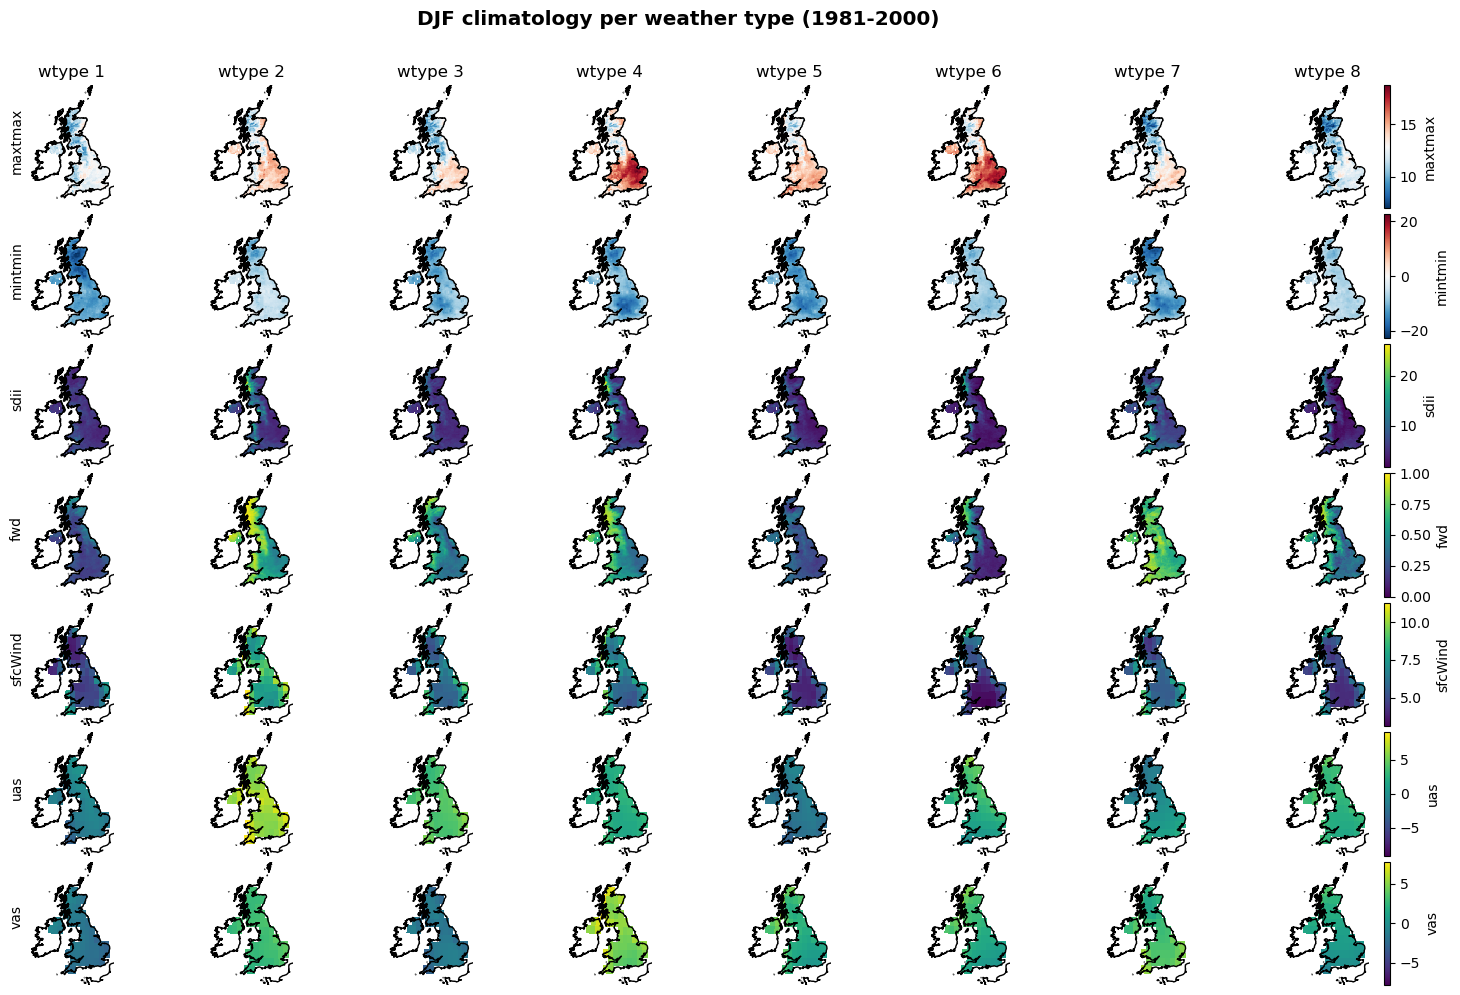

In [115]:
fig, axs = plt.subplots(ncols = 8, nrows = len(inds), figsize = (15,10), sharex = True, sharey = True, subplot_kw = { "projection" : rg.crs["uk_map"]}, dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle("DJF climatology per weather type (1981-2000)" , size='x-large', fontweight = "bold", y = 0.995)
fig.subplots_adjust(hspace = 0.05, wspace = 0.05, top = 0.92, left = 0.01, right = 0.99, bottom = 0.02)

# label with index names & weather types
for i in range(8):
    axs[0,i].set_title("wtype "+str(i+1))
    maxtmax_cbar = axs[0,i].pcolormesh(pr.projection_x_coordinate, pr.projection_y_coordinate, maxtmax.sel(season = "DJF").sel(wtype = (i+1)), **vrange(maxtmax.sel(season = "DJF")), cmap = "RdBu_r")
    mintmin_cbar = axs[1,i].pcolormesh(pr.projection_x_coordinate, pr.projection_y_coordinate, mintmin.sel(season = "DJF").sel(wtype = (i+1)), **vrange(mintmin.sel(season = "DJF")), cmap = "RdBu_r")
    sdii_cbar = axs[2,i].pcolormesh(pr.projection_x_coordinate, pr.projection_y_coordinate, sdii.sel(season = "DJF").sel(wtype = (i+1)), **vrange(sdii.sel(season = "DJF")))
    fwd_cbar = axs[3,i].pcolormesh(pr.projection_x_coordinate, pr.projection_y_coordinate, fwd.where(fwd > 0).sel(season = "DJF").sel(wtype = (i+1)), vmin = 0, vmax = 1)
    sfcWind_cbar = axs[4,i].pcolormesh(era_lsm.x_vertices, era_lsm.y_vertices, sfcWind.sel(season = "DJF").sel(wtype = (i+1)), **vrange(sfcWind.sel(season = "DJF")), transform = rg.crs["uk_map"])
    uas_cbar = axs[5,i].pcolormesh(era_lsm.x_vertices, era_lsm.y_vertices, uas.sel(season = "DJF").sel(wtype = (i+1)), **vrange(uas.sel(season = "DJF")), transform = rg.crs["uk_map"])
    vas_cbar = axs[6,i].pcolormesh(era_lsm.x_vertices, era_lsm.y_vertices, vas.sel(season = "DJF").sel(wtype = (i+1)), **vrange(vas.sel(season = "DJF")), transform = rg.crs["uk_map"])
            
# for all suplots set same geographical extent, hide axes
for axz in fig.axes:
    axz.set_extent((-2e5, 7e5, -1e5, 12.2e5), crs = rg.crs["uk_map"])
    axz.set_axis_off()
    axz.coastlines()

for j in range(len(inds)): 
    axs[j,0].text(-0.07, 0.55, inds[j], va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform = axs[j,0].transAxes)
    plt.colorbar(eval(inds[j] + "_cbar"), ax = axs[j,:], fraction = 0.02, pad = 0.01, label = inds[j])

In [116]:
summ = [[i] + eval(i).sel(season = "DJF").mean([d for d in eval(i).dims if not d in ["wtype", "season"]]).values.tolist() for i in inds]
summ_df = pd.DataFrame.from_records(summ, columns = ["Variable"] + list(range(9)[1:]))

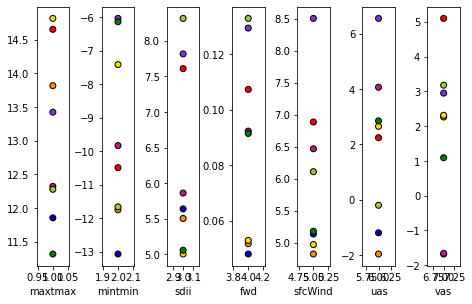

In [117]:
fig, axs = plt.subplots(ncols = len(inds))
fig.subplots_adjust(hspace = 0.05, wspace = 1, top = 0.92, left = 0.01, right = 0.99, bottom = 0.02)

for i in range(len(inds)):
    axs[i].scatter(np.repeat(i+1,8), summ[i][1:], color = wtype_cols, edgecolor = "black")
    axs[i].set_xlabel(summ[i][0])

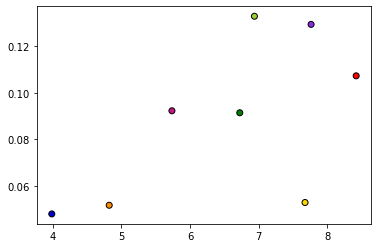

In [108]:
plt.scatter(summ[inds.index("maxtmax")][1:], summ[inds.index("fwd")][1:], color = wtype_cols, edgecolor = "black")

---
### **Frequencies of weather types during the evaluation period**

In [6]:
# compute proportions for 'observed' weather types
era = xr.open_dataset("/data/met/ECMWF-ERAINT/ka2/wtype30_ECMWF-ERAINT_day_19801201-20001130.nc").wtype30
era8 = xr.open_dataset("/data/met/ECMWF-ERAINT/ka2/wtype8_ECMWF-ERAINT_day_19801201-20001130.nc").wtype8

wtype_props = [["ECMWF-ERAINT", "DJF"] + list(np.bincount(era.sel(time = era.time.dt.season == "DJF"))[1:] / (era.time.dt.season == "DJF").sum().values)]
wtype_props.append(["ECMWF-ERAINT", "JJA"] + list(np.bincount(era.sel(time = era.time.dt.season == "JJA"))[1:] / (era.time.dt.season == "JJA").sum().values))

wtype8_props = [["ECMWF-ERAINT", "DJF"] + list(np.bincount(era8.sel(time = era8.time.dt.season == "DJF"))[1:] / (era8.time.dt.season == "DJF").sum().values)]
wtype8_props.append(["ECMWF-ERAINT", "JJA"] + list(np.bincount(era8.sel(time = era8.time.dt.season == "JJA"))[1:] / (era8.time.dt.season == "JJA").sum().values))

# add proportions for GCMs & UKCP18 runs
for fnm in sorted(glob.glob("/data/met/cmip5/*/*/ka2/wtype30_*") + glob.glob("/data/met/ukcp18/*/ka2/wtype30_*COMPUTED.nc")):
    
    ds = xr.open_dataset(fnm).sel(time = slice("19801201", "20001130")).squeeze(drop = True).wtype30.astype(int)
    ds8 = xr.open_dataset(re.sub("wtype30", "wtype8", fnm)).sel(time = slice("19801201", "20001130")).squeeze(drop = True).wtype8.astype(int)
    
    if "cmip5" in fnm:
        model = re.sub("/ka2.+","",re.sub(".+cmip5/","",fnm))
    else:
        model = "UKCP18-" + re.sub("/.+","",re.sub(".+ukcp18/","",fnm))
        
    for s in np.unique(ds.time.dt.season):
        counts = np.bincount(ds.sel(time = ds.time.dt.season == s))
        wtype_props.append([model, s] + list(counts[1:] / sum(counts)))
        
        counts8 = np.bincount(ds8.sel(time = ds8.time.dt.season == s))
        wtype8_props.append([model, s] + list(counts8[1:] / sum(counts8)))

wtype_props = pd.DataFrame.from_records(wtype_props, columns = ["model", "season"] + list(range(31)[1:])).iloc[::-1]
wtype8_props = pd.DataFrame.from_records(wtype8_props, columns = ["model", "season"] + list(range(9)[1:])).iloc[::-1]

Text(0.5, 1, 'Proportion of days assigned to each weather type by each GCM')

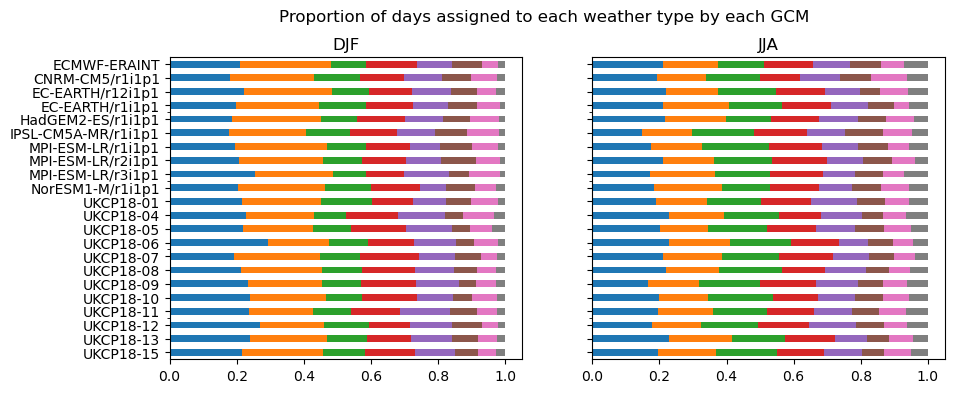

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (10,4), dpi = 100, facecolor = 'w', edgecolor = 'k')

wtype8_props[wtype8_props["season"] == "DJF"].plot.barh(ax = ax1, stacked = True, legend = False, x = "model", title = "DJF", xlabel = "")
wtype8_props[wtype8_props["season"] == "JJA"].plot.barh(ax = ax2, stacked = True, legend = False, x = "model", title = "JJA", xlabel = "")

fig.suptitle("Proportion of days assigned to each weather type by each GCM", y = 1)

In [10]:
wtype8_props[wtype8_props.model == "ECMWF-ERAINT"]

,model,season,1,2,3,4,5,6,7,8
1,ECMWF-ERAINT,JJA,0.211413,0.163587,0.136413,0.146739,0.110326,0.092391,0.067391,0.071739
0,ECMWF-ERAINT,DJF,0.210526,0.269806,0.103601,0.154017,0.102493,0.091413,0.046537,0.021607


Text(0.5, 1, 'Proportion of days assigned to each weather type by each GCM')

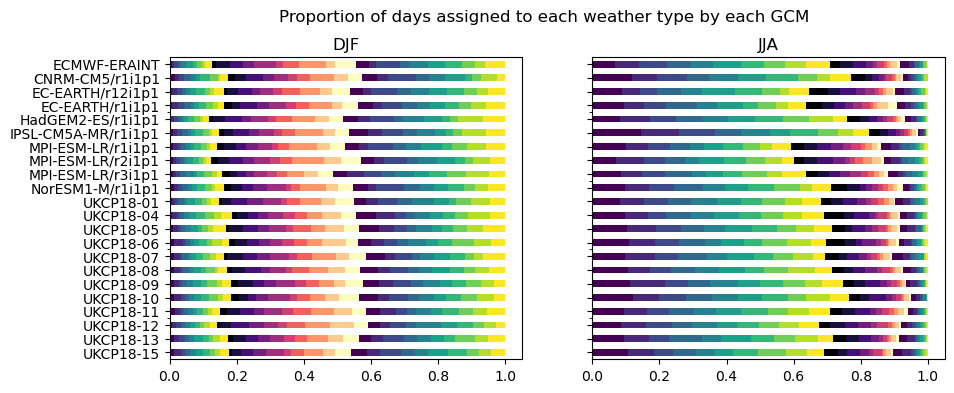

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (10,4), dpi = 100, facecolor = 'w', edgecolor = 'k')

# create a hybrid colour scheme to highlight difference in proportions
colours = np.vstack((cm.get_cmap('viridis', 10).colors, cm.get_cmap('magma', 10).colors, cm.get_cmap('viridis', 10).colors))

wtype_props[wtype_props["season"] == "DJF"].plot.barh(ax = ax1, stacked = True, legend = False, x = "model", title = "DJF", xlabel = "", color = colours)
wtype_props[wtype_props["season"] == "JJA"].plot.barh(ax = ax2, stacked = True, legend = False, x = "model", title = "JJA", xlabel = "", color = colours)

fig.suptitle("Proportion of days assigned to each weather type by each GCM", y = 1)

---
### **Summaries of weather types for EuroCORDEX projections**


#### **Weather type frequencies over 100-year period**

In [20]:
wtype_props = []
wtype_props_per_month = []
wtype_props_per_season = []

for fnm in sorted(glob.glob("/data/met/cmip5/*/*/ka2/wtype30*") + glob.glob("/data/met/ukcp18/*/ka2/wtype30*")):
    
    ds = xr.open_dataset(fnm).sel(time = slice("19801201", "20801130")).squeeze(drop = True)
    
    if "cmip5" in fnm:
        model = re.sub("/ka2.+","",re.sub(".+cmip5/","",fnm))
    else:
        model = "UKCP18-" + re.sub("/.+","",re.sub(".+ukcp18/","",fnm))
        ds["wtype30"] = ds.wtype30.astype(int)
    
    wtype_props.append([model] + list(np.bincount(ds.wtype30)[1:]))
    
    for s in np.unique(ds.time.dt.season):
        counts = np.bincount(ds.wtype30.sel(time = ds.time.dt.season == s))
        wtype_props_per_season.append([model, s] + list(counts[1:] / sum(counts)))
    
    for m in np.unique(ds.time.dt.month):
        counts = np.bincount(ds.wtype30.sel(time = ds.time.dt.month == m))
        wtype_props_per_month.append([model, str(m)] + list(counts[1:] / sum(counts)))


wtype_props = pd.DataFrame.from_records(wtype_props, columns = ["model"] + list(range(31)[1:]))
wtype_props_per_month = pd.DataFrame.from_records(wtype_props_per_month, columns = ["model", "month"] + list(range(31)[1:])).iloc[::-1]
wtype_props_per_season = pd.DataFrame.from_records(wtype_props_per_season, columns = ["model", "season"] + list(range(31)[1:])).iloc[::-1]

Text(0.5, 1, 'Proportion of days assigned to each weather type by each GCM')

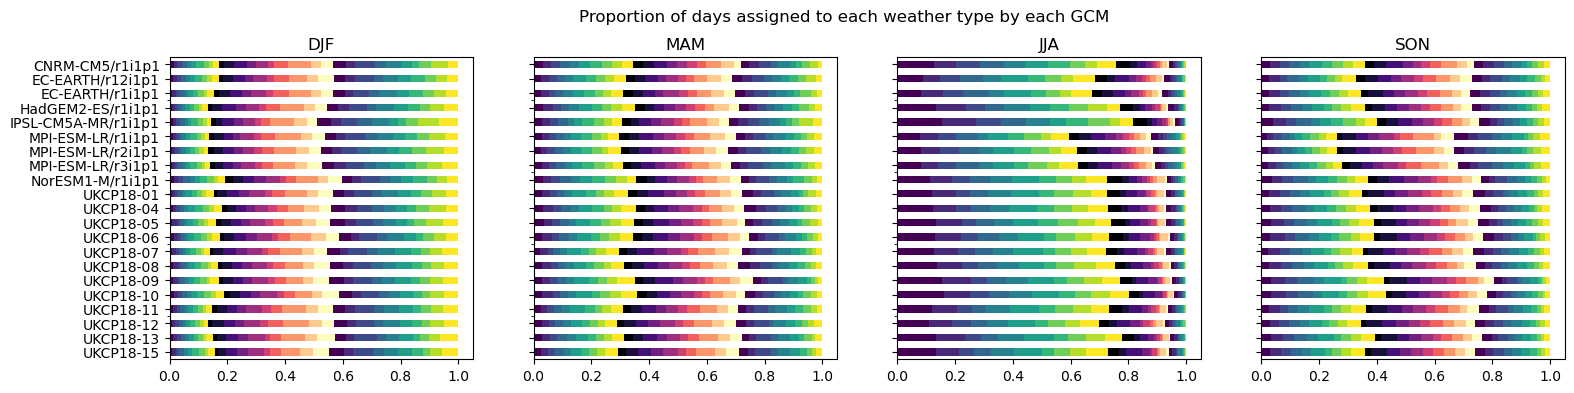

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, sharex = True, sharey = True, figsize = (18,4), dpi = 100, facecolor = 'w', edgecolor = 'k')

# create a hybrid colour scheme to highlight difference in proportions
colours = np.vstack((cm.get_cmap('viridis', 10).colors, cm.get_cmap('magma', 10).colors, cm.get_cmap('viridis', 10).colors))

wtype_props_per_season[wtype_props_per_season["season"] == "DJF"].plot.barh(ax = ax1, stacked = True, legend = False, x = "model", title = "DJF", xlabel = "", color = colours)
wtype_props_per_season[wtype_props_per_season["season"] == "MAM"].plot.barh(ax = ax2, stacked = True, legend = False, x = "model", title = "MAM", xlabel = "", color = colours)
wtype_props_per_season[wtype_props_per_season["season"] == "JJA"].plot.barh(ax = ax3, stacked = True, legend = False, x = "model", title = "JJA", xlabel = "", color = colours)
wtype_props_per_season[wtype_props_per_season["season"] == "SON"].plot.barh(ax = ax4, stacked = True, legend = False, x = "model", title = "SON", xlabel = "", color = colours)

fig.suptitle("Proportion of days assigned to each weather type by each GCM", y = 1)

#### **Weather type frequencies per 30-year time slice for a single model**

In [ ]:
# will eventually need to loop over all the models - set up filenames to accommodate this
fnm = glob.glob("/data/met/ukcordex/*/*/*/dmo/tas_natgb_*_day_19801201-20801130.nc")[0]

# load all the data
wtype = xr.open_mfdataset("/data/met/cmip5/*" + re.sub(".+-","",re.sub("ukcordex", "cmip5", re.sub("/.+/","/",re.sub("/dmo.+","",re.sub(".+ukcordex/","",fnm))))) + "/ka2/wtype30_*.nc")

tas = xr.open_dataset(fnm).merge(wtype)
tasmin = xr.open_dataset(re.sub("tas", "tasmin", fnm)).merge(wtype)
tasmax = xr.open_dataset(re.sub("tas", "tasmax", fnm)).merge(wtype)
pr = xr.open_dataset(re.sub("tas", "pr", fnm)).merge(wtype)
sfcWind = xr.open_dataset(re.sub("tas", "sfcWind", fnm)).merge(wtype)
sfcWindmax = xr.open_dataset(re.sub("tas", "sfcWindmax", fnm)).merge(wtype)

model_ref = tas.driving_model_id + "_" + tas.driving_model_ensemble_member + "_" + tas.model_id

In [3]:
# count weather type frequencies per 30-year time slice
wtype_props = []
wtype_props_per_month = []
wtype_props_per_season = []

slice_length = 30
for y in [1996, 2005, 2015, 2025, 2035, 2045, 2055, 2065]:
    
    sl_start = str(y-(int(slice_length/2))-1) + "1201"
    sl_end = str(y+(int(slice_length/2))-1) + "1130"
    
    da = wtype.sel(time = slice(sl_start, sl_end)).wtype30
    wtype_props.append([sl_start + "-" + sl_end] + list(np.bincount(da)[1:] / len(da)))
    
    for s in np.unique(da.time.dt.season):
        counts = np.bincount(da.sel(time = da.time.dt.season == s))
        wtype_props_per_season.append([sl_start + "-" + sl_end, s] + list(counts[1:] / sum(counts)))
    
    for m in np.unique(da.time.dt.month):
        counts = np.bincount(da.sel(time = da.time.dt.month == m))
        wtype_props_per_month.append([sl_start + "-" + sl_end, str(m)] + list(counts[1:] / sum(counts)))
    
wtype_props = pd.DataFrame.from_records(wtype_props, columns = ["slice"] + list(range(31)[1:]))
wtype_props_per_month = pd.DataFrame.from_records(wtype_props_per_month, columns = ["slice", "month"] + list(range(31)[1:])).iloc[::-1]
wtype_props_per_season = pd.DataFrame.from_records(wtype_props_per_season, columns = ["slice", "season"] + list(range(31)[1:])).iloc[::-1]
# pd.DataFrame.iloc[::-1] reverses the order of the rows, ensuring that the slices are plotted in the right order.
# use string for months - otherwise the bar stacking starts, rather annoyingly, from m

In [202]:
# climatologies per 30-year time slice

### **Some plots...**

#### **Proportion of days assigned to each weather type per slice & season**

Text(0.5, 1, 'Proportion of days assigned to each weather type: CNRM-CERFACS-CNRM-CM5_r1i1p1_MOHC-HadREM3-GA7-05')

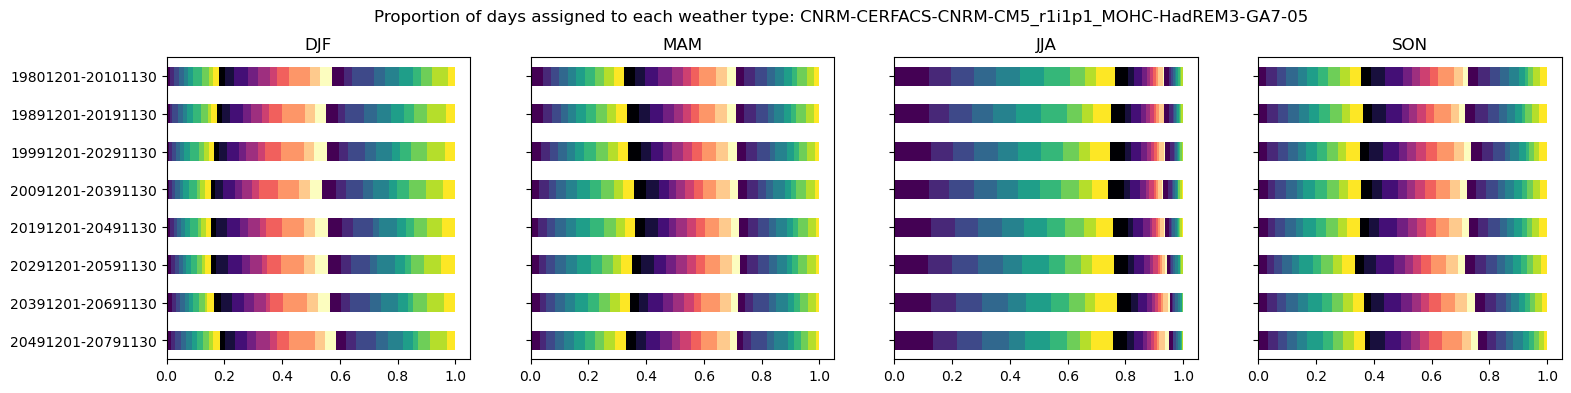

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, sharex = True, sharey = True, figsize = (18,4), dpi = 100, facecolor = 'w', edgecolor = 'k')

# create a hybrid colour scheme to highlight difference in proportions
colours = np.vstack((cm.get_cmap('viridis', 10).colors, cm.get_cmap('magma', 10).colors, cm.get_cmap('viridis', 10).colors))

wtype_props_per_season[wtype_props_per_season["season"] == "DJF"].plot.barh(ax = ax1, stacked = True, legend = False, x = "slice", title = "DJF", xlabel = "", color = colours)
wtype_props_per_season[wtype_props_per_season["season"] == "MAM"].plot.barh(ax = ax2, stacked = True, legend = False, x = "slice", title = "MAM", xlabel = "", color = colours)
wtype_props_per_season[wtype_props_per_season["season"] == "JJA"].plot.barh(ax = ax3, stacked = True, legend = False, x = "slice", title = "JJA", xlabel = "", color = colours)
wtype_props_per_season[wtype_props_per_season["season"] == "SON"].plot.barh(ax = ax4, stacked = True, legend = False, x = "slice", title = "SON", xlabel = "", color = colours)

fig.suptitle("Proportion of days assigned to each weather type: " + model_ref, y = 1)

#### **Proportion of days assigned to each weather type per slice & month**

Text(0.5, 0.95, 'Proportion of days assigned to each weather type: CNRM-CERFACS-CNRM-CM5_r1i1p1_MOHC-HadREM3-GA7-05')

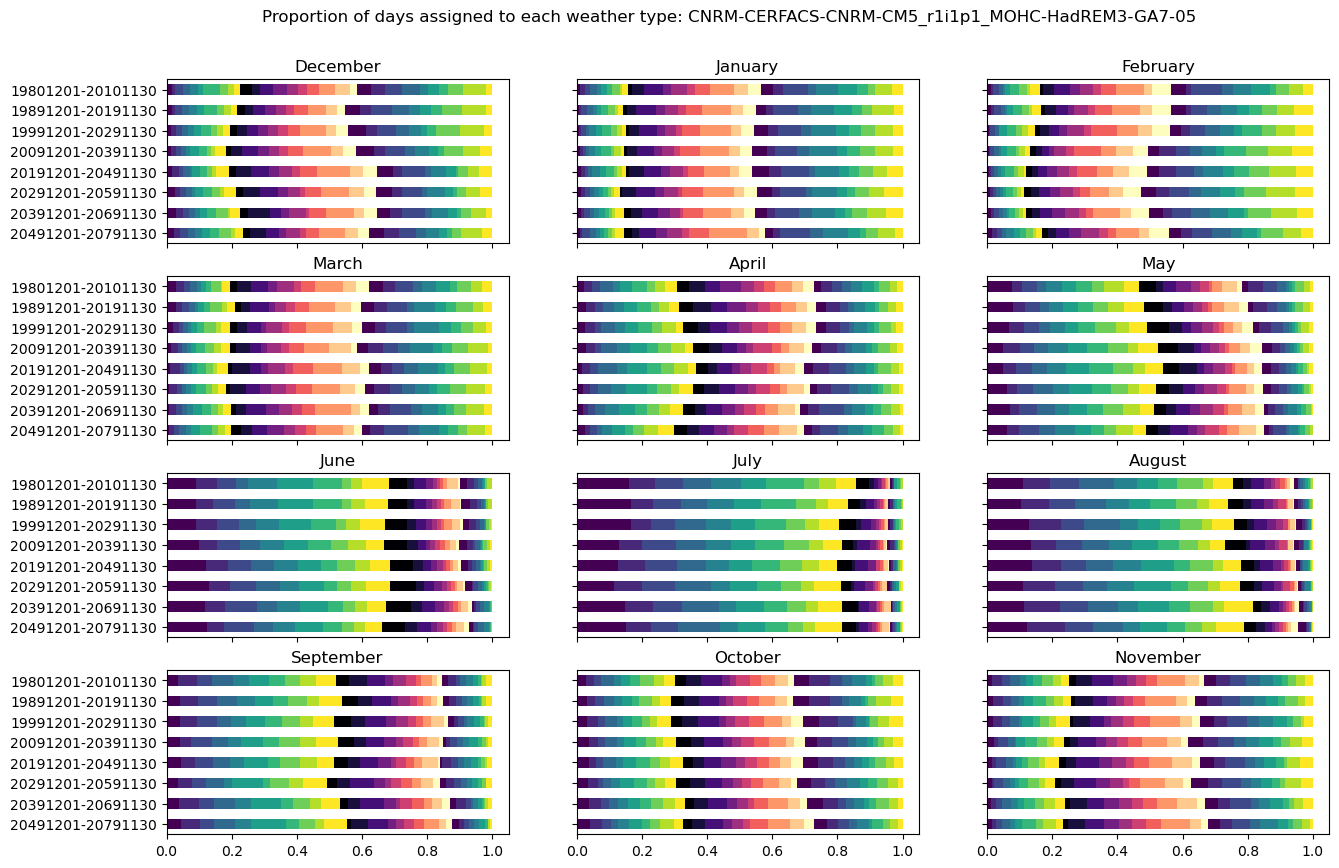

In [203]:
fig, ((ax12, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8), (ax9, ax10, ax11)) = plt.subplots(ncols = 3, nrows = 4, sharex = True, sharey = True, figsize = (15,10), dpi = 100, facecolor = 'w', edgecolor = 'k')

# create a hybrid colour scheme to highlight difference in proportions
colours = np.vstack((cm.get_cmap('viridis', 10).colors, cm.get_cmap('magma', 10).colors, cm.get_cmap('viridis', 10).colors))

for m in [12] + list(range(12)[1:]):
    wtype_props_per_month[wtype_props_per_month["month"] == str(m)].plot.barh(ax = eval("ax"+str(m)), stacked = True, legend = False, x = "slice", title = calendar.month_name[m], xlabel = "", color = colours)
    
fig.suptitle("Proportion of days assigned to each weather type: " + model_ref, y = 0.95)

---
#### **How decisively is each weather type identified?**

In [17]:
wtype = xr.open_mfdataset("/data/met/cmip5/HadGEM2-ES/r1i1p1/ka2/wtype30*_rcp85_land-indices_HadGEM2-ES_r1i1p1_day_19801201-20801130.nc")

ss = wtype.ss.sel(regime = wtype.wtype30)
corr = wtype.corr.sel(regime = wtype.wtype30)

In [25]:
counts = np.bincount(wtype.wtype30.sel(time = wtype.time.dt.season == "DJF").squeeze())[1:]
squares = 

In [ ]:
wtype.sel(time = ss.time.dt.season == "DJF").groupby(wtype.wtype30).ss.mean(dim = "time")